# Analysis of KP1.9 mouse lung adenocarcinoma scRNA-seq data

In this notebook we re-analyze KP1.9 mouse lung adenocarcinoma single-cell transcriptome data from https://doi.org/10.1016/j.immuni.2019.03.009 and obtained from GSE127465: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE127465. Fig. S4A-D, S4G, S5B, & S6B-C were generated using the code in this notebook.

In [49]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import anndata
import itertools
import functools
from time import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import multiprocessing
import mm_functions_14_10_2020 as mm

In [50]:
# Set figure parameters 
mylines = 0.15*2.82 # the number 2.82 is the difference
					# between Illustrator 1 pt and python 1 pt.
mpl.rcParams['axes.linewidth'] = mylines # default 1
mpl.rcParams['ytick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.major.size'] = 2 # default 4
mpl.rcParams['ytick.major.size'] = 2 # default 4
mpl.rcParams['xtick.major.width'] = mylines # default 0.5
mpl.rcParams['ytick.major.width'] = mylines # default 0.5
mpl.rcParams['grid.linewidth'] = mylines/1.5 # default 0.5
mpl.rcParams['grid.color'] = '0.8' # default 'k'
mpl.rcParams['grid.linestyle'] = 'solid'# default ':'
mpl.rcParams['legend.frameon'] = False # default True
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [51]:
adata = sc.read_h5ad('/Users/mariusmessemaker/Documents/Project/mempel/backups/adata_zilionis_05202020.h5ad')

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [52]:
adata.obs

,Tumor or healthy,Biological replicate,Library,Barcode,Library prep batch,Total counts,Percent counts from mitochondrial genes,Most likely Immgen cell type,Major cell type,state,x,y
0,t,Tumor-bearing 1,t_1_1,bc0001,round1_20151128,7927.0,3.393000,MF_Thio5_II+480int_PC,MoMacDC,Mac1,1174.120533,-217.075559
1,t,Tumor-bearing 1,t_1_1,bc0002,round1_20151128,5665.0,6.461000,DC_103-11b+24+_Lu,MoMacDC,DC1,1068.808968,-37.966851
2,t,Tumor-bearing 1,t_1_1,bc0003,round1_20151128,4615.0,2.579000,DC_8-4-11b+_SLN,MoMacDC,DC3,791.206113,-51.756695
3,t,Tumor-bearing 1,t_1_1,bc0004,round1_20151128,5353.0,3.082000,DC_8+_Th,MoMacDC,DC1,1068.688851,-17.459386
4,t,Tumor-bearing 1,t_1_1,bc0005,round1_20151128,4653.0,2.901000,DC_8-4-11b+_SLN,MoMacDC,DC3,805.516538,-52.706709
...,...,...,...,...,...,...,...,...,...,...,...,...
15934,t,Tumor-bearing 2,t_2_4,bc1083,round3_20160313,1082.0,6.561922,T_8Nve_Sp_OT1,T cells,T1,722.864953,622.365393
15935,t,Tumor-bearing 2,t_2_4,bc1084,round3_20160313,912.0,3.837719,B_Fo_Sp,B cells,B cells,240.758904,292.600115
15936,t,Tumor-bearing 2,t_2_4,bc1085,round3_20160313,926.0,5.507559,GN_UrAc_PC,Neutrophils,N4,1037.348649,-796.034347
15937,t,Tumor-bearing 2,t_2_4,bc1086,round3_20160313,795.0,0.628931,GN_Arth_SynF,Neutrophils,N3,413.387190,-650.431908


In [53]:
adata = mm.filter_cells_adata(adata, col1 = 'Tumor or healthy', flist1 = ['t'], 
                             # col2 = 'Major cell type', flist2 = ['T cells', 'B cells', 'NK cells'], isnot2 = True
                             )

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


9201 cells will survive Tumor or healthy filtering.

Shape before filtering: (15939, 28205)
Shape after filtering: (9201, 28205) 

Tumor or healthy unique values after filtering: ['t'] 



## Fig. S4A: SSPRING plot coloured by cell states

In [54]:
color_dict = {}
color_dict['zilionis'] = {
 'Mac1':'#ff3399',
 'DC1':'#ff0000',
 'DC3':'#990000',
 'Mono3':'#0099ff',
 'Mac2':'#66ffff',
 'N4':'#12a9d3',
 'T2':'#ba0899',
 'Mono1':'#e2e74b',
 'T3':'#cc263c',
 'T1':'#ffd900',
 'N1':'#0a5e75',
 'N5':'#666699',
 'DC2':'#ff9900',
 'N6':'#ee2c7d',
 'Mac3':'#9966ff',
 'pDC':'#a094ff',
 'NK cells':'#1f6935',
 'MonoDC':'#00cc00',
 'B cells':'#4666b0',
 'Mono2':'#6d700f',
 'N2':'#66ffcc',
 'Mac4':'#33cccc',
 'Basophils':'#4c2e4d',
 'N3':'#008055', 
 'Unknown':'#808080', 
 'non-immune':'#c4c4c4'
}

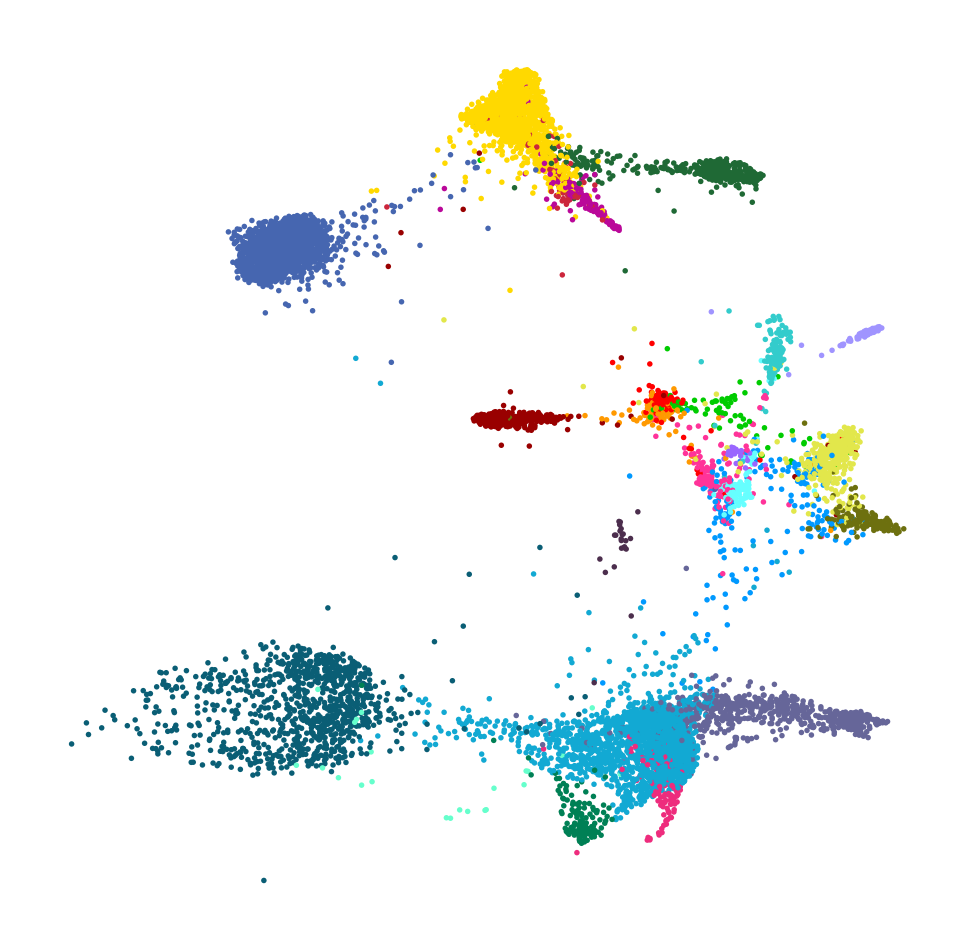

In [55]:
a,fig,gs=mm.startfig(10, 10)
a.scatter(adata.obs['x'],adata.obs['y'],c=adata.obs['state'].values.map(color_dict['zilionis']),
          s = 1.75, edgecolors='none')
a.spines['top'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)
a.spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig('./outputs/KP19/state_spring.pdf')

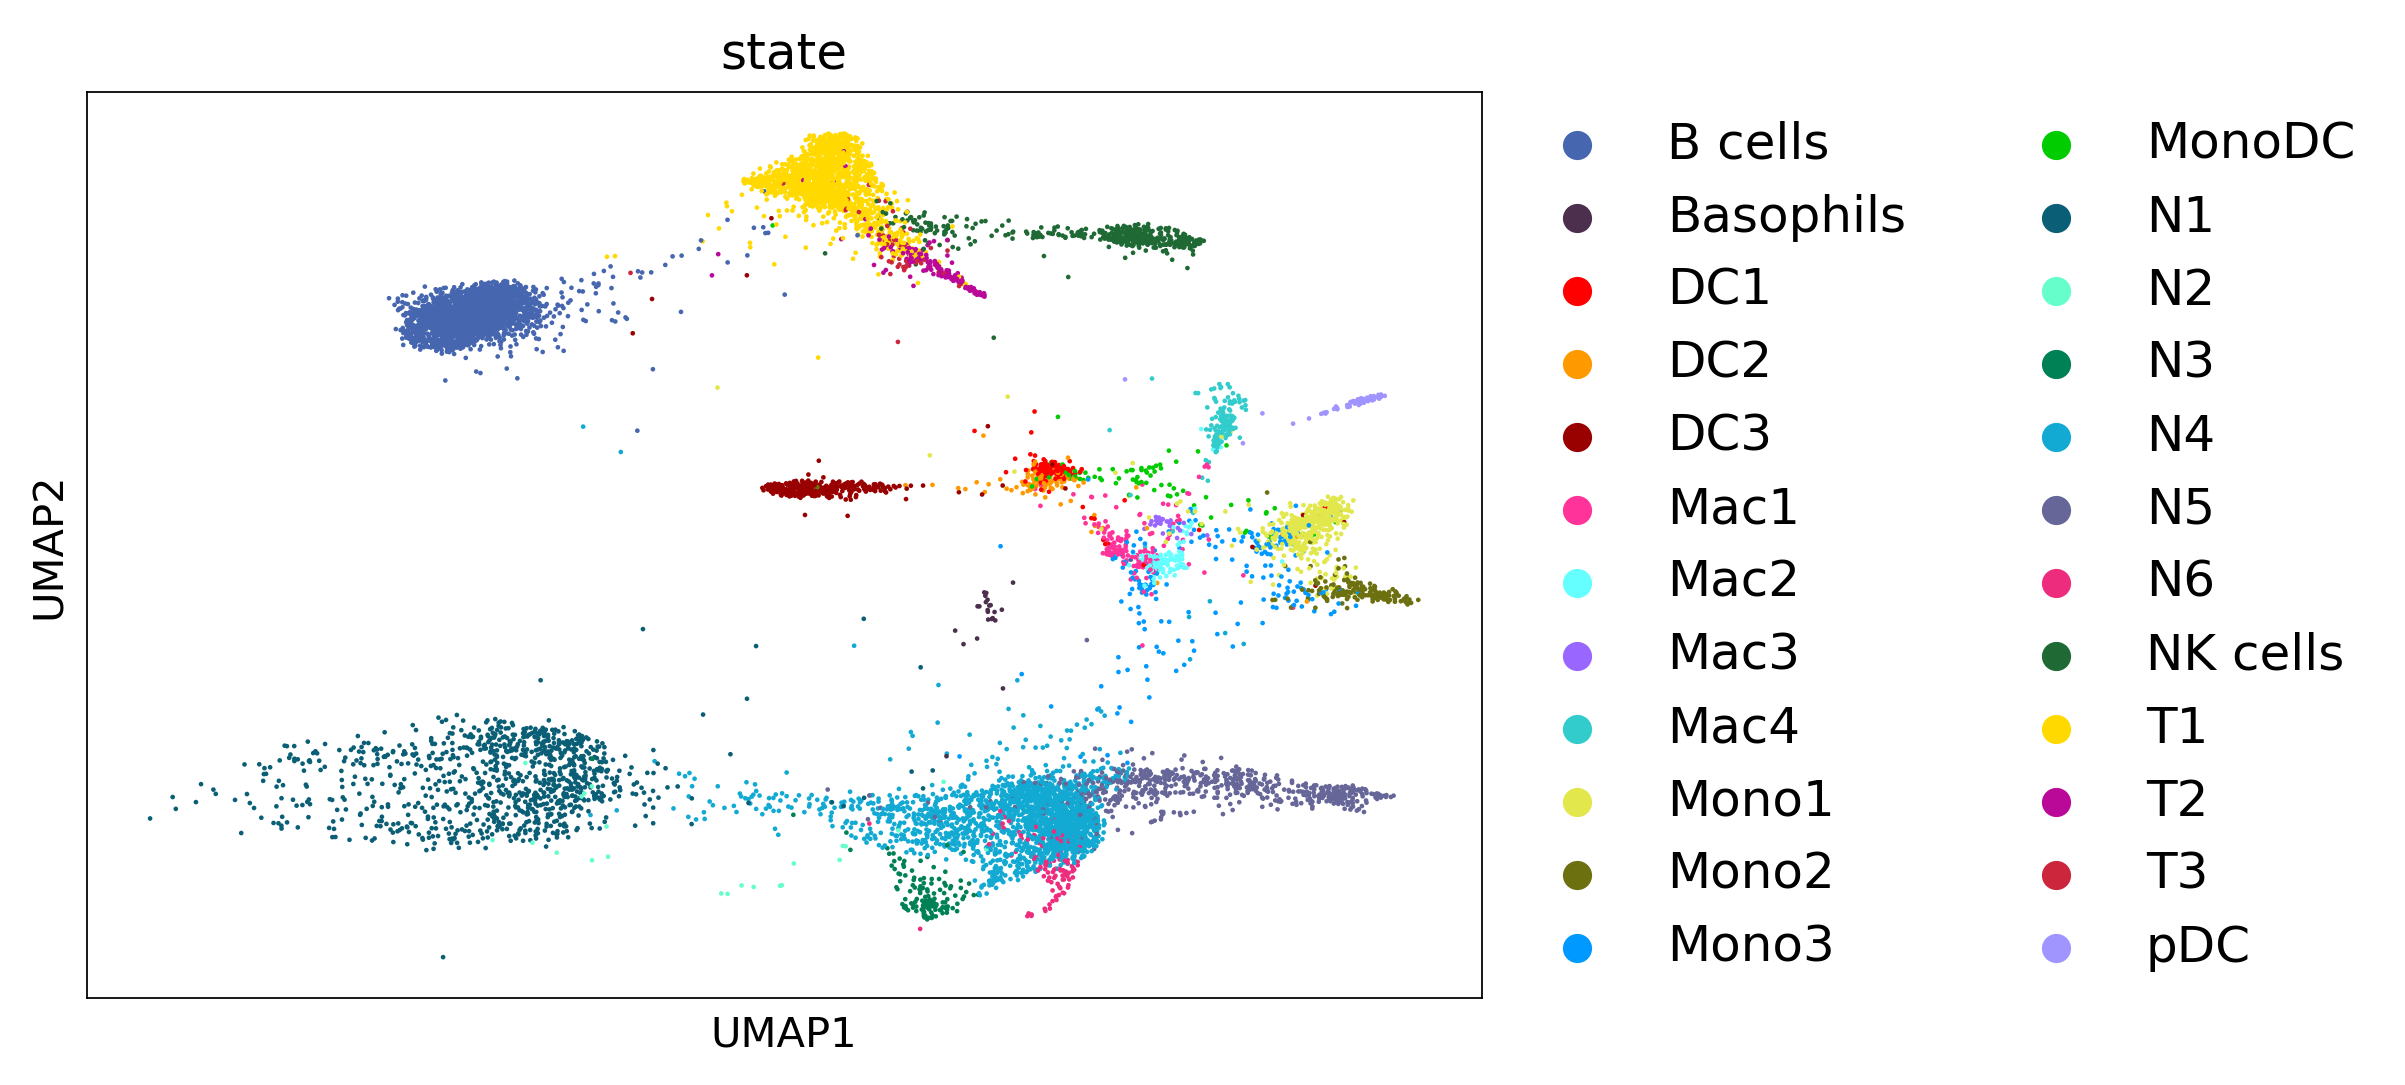

In [56]:
# plot cell state legend using Scanpy: 
adata.obsm['X_umap'] = np.array([adata.obs['x'].values, adata.obs['y'].values]).T
adata.uns['state_colors'] = [color_dict['zilionis'][state] for state in adata.obs['state'].cat.categories]
sc.pl.umap(adata, color = 'state', s = 5, legend_fontsize = 12)

## Fig. S4B,S4D,S4G,S5B, & S6B: Myeloid SPRING plots coloured by gene expression

In [57]:
for gene in ['Fscn1', 'Cd80', 'Lamp3', 'Il15', 'Il15ra', 'Il12b', 'Cxcl16', 'Cxcl9', 'Cxcl5', 'Cxcl10', 'Ccr7', 'Ccl5']:
    gmask = adata.var_names == gene 
    expression = np.array(adata.X[:,gmask].todense()).T[0]
    order = np.argsort(expression)
    a,fig,gs=mm.startfig(10, 10)
    vmax = np.percentile(expression,99) # Saturate at 99.9th percentile
    a.scatter(adata.obs['x'].values[order],adata.obs['y'].values[order],c=expression[order],
              vmax=vmax, cmap = mm.custom_colormap(['#000000','#00ff00']), s = 1.75, edgecolors='none')
    a.set_title(gene)
    plt.xticks([])
    plt.yticks([])
    a.spines['top'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    plt.savefig('./outputs/KP19/' + gene + '.pdf')
    plt.close()
    #cbar = plt.colorbar(scat)

In [58]:
tmp_adata = mm.filter_cells_adata(adata, col1 = 'Major cell type', flist1 = ['T cells', 'B cells', 'NK cells', 'Neutrophils', 'Basophils'], isnot1 = True)

1820 cells will survive Major cell type filtering.

Shape before filtering: (9201, 28205)
Shape after filtering: (1820, 28205) 

Major cell type unique values after filtering: ['MoMacDC', 'pDC'] 



/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [59]:
for gene in ['Fscn1', 'Cd80', 'Lamp3', 'Il15', 'Il15ra', 'Il12b', 'Cxcl16', 'Cxcl9', 'Cxcl5', 'Cxcl10', 'Ccr7', 'Ccl5']:
    gmask = tmp_adata.var_names == gene 
    expression = np.array(tmp_adata.X[:,gmask].todense()).T[0]
    order = np.argsort(expression)
    a,fig,gs=mm.startfig(10, 10)
    vmax = np.percentile(expression,99) # Saturate at 99.9th percentile
    a.scatter(tmp_adata.obs['x'].values[order],tmp_adata.obs['y'].values[order],c=expression[order],
              vmax=vmax, cmap = mm.custom_colormap(['#000000','#00ff00']), s = 1.75, edgecolors='none')
    a.set_title(gene)
    plt.xticks([])
    plt.yticks([])
    a.spines['top'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    plt.savefig('./outputs/KP19/myeloid_' + gene + '.pdf')
    plt.close()
    #cbar = plt.colorbar(scat)

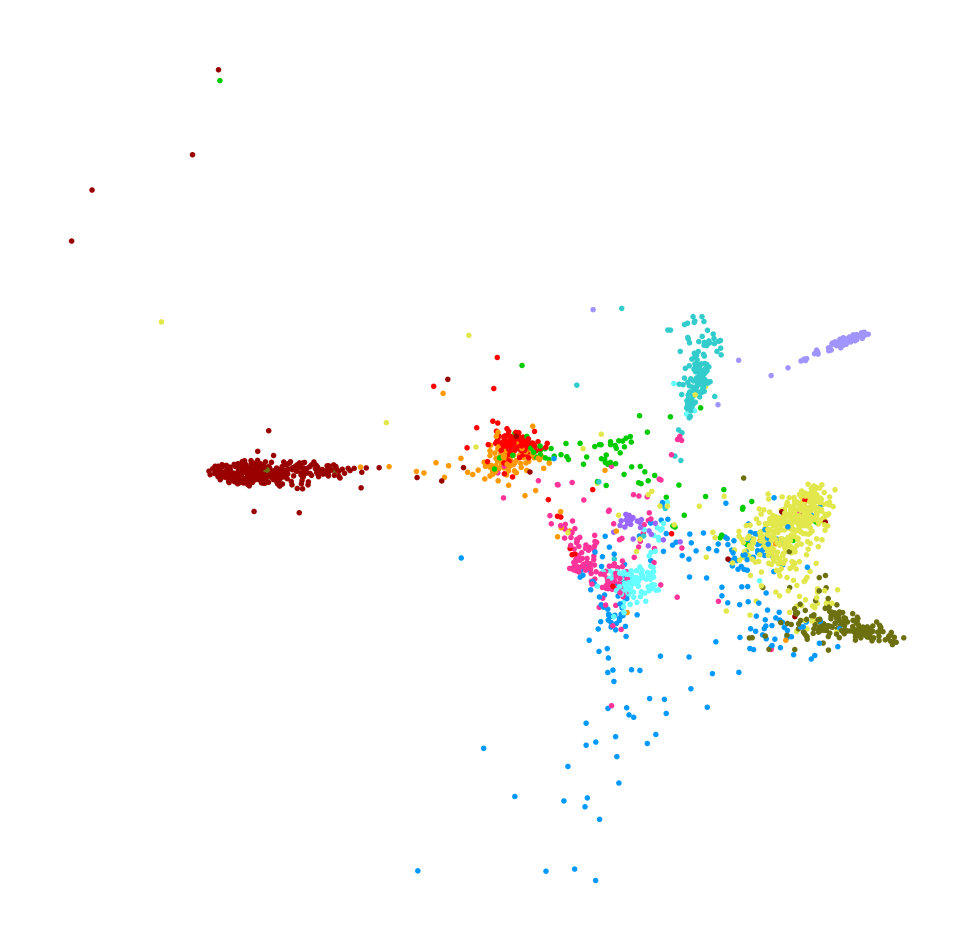

In [60]:
a,fig,gs=mm.startfig(10, 10)
a.scatter(tmp_adata.obs['x'],tmp_adata.obs['y'],c=tmp_adata.obs['state'].values.map(color_dict['zilionis']),
          s = 1.75, edgecolors='none')
a.spines['top'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)
a.spines['right'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig('./outputs/KP19/myeloid_state_spring.pdf')

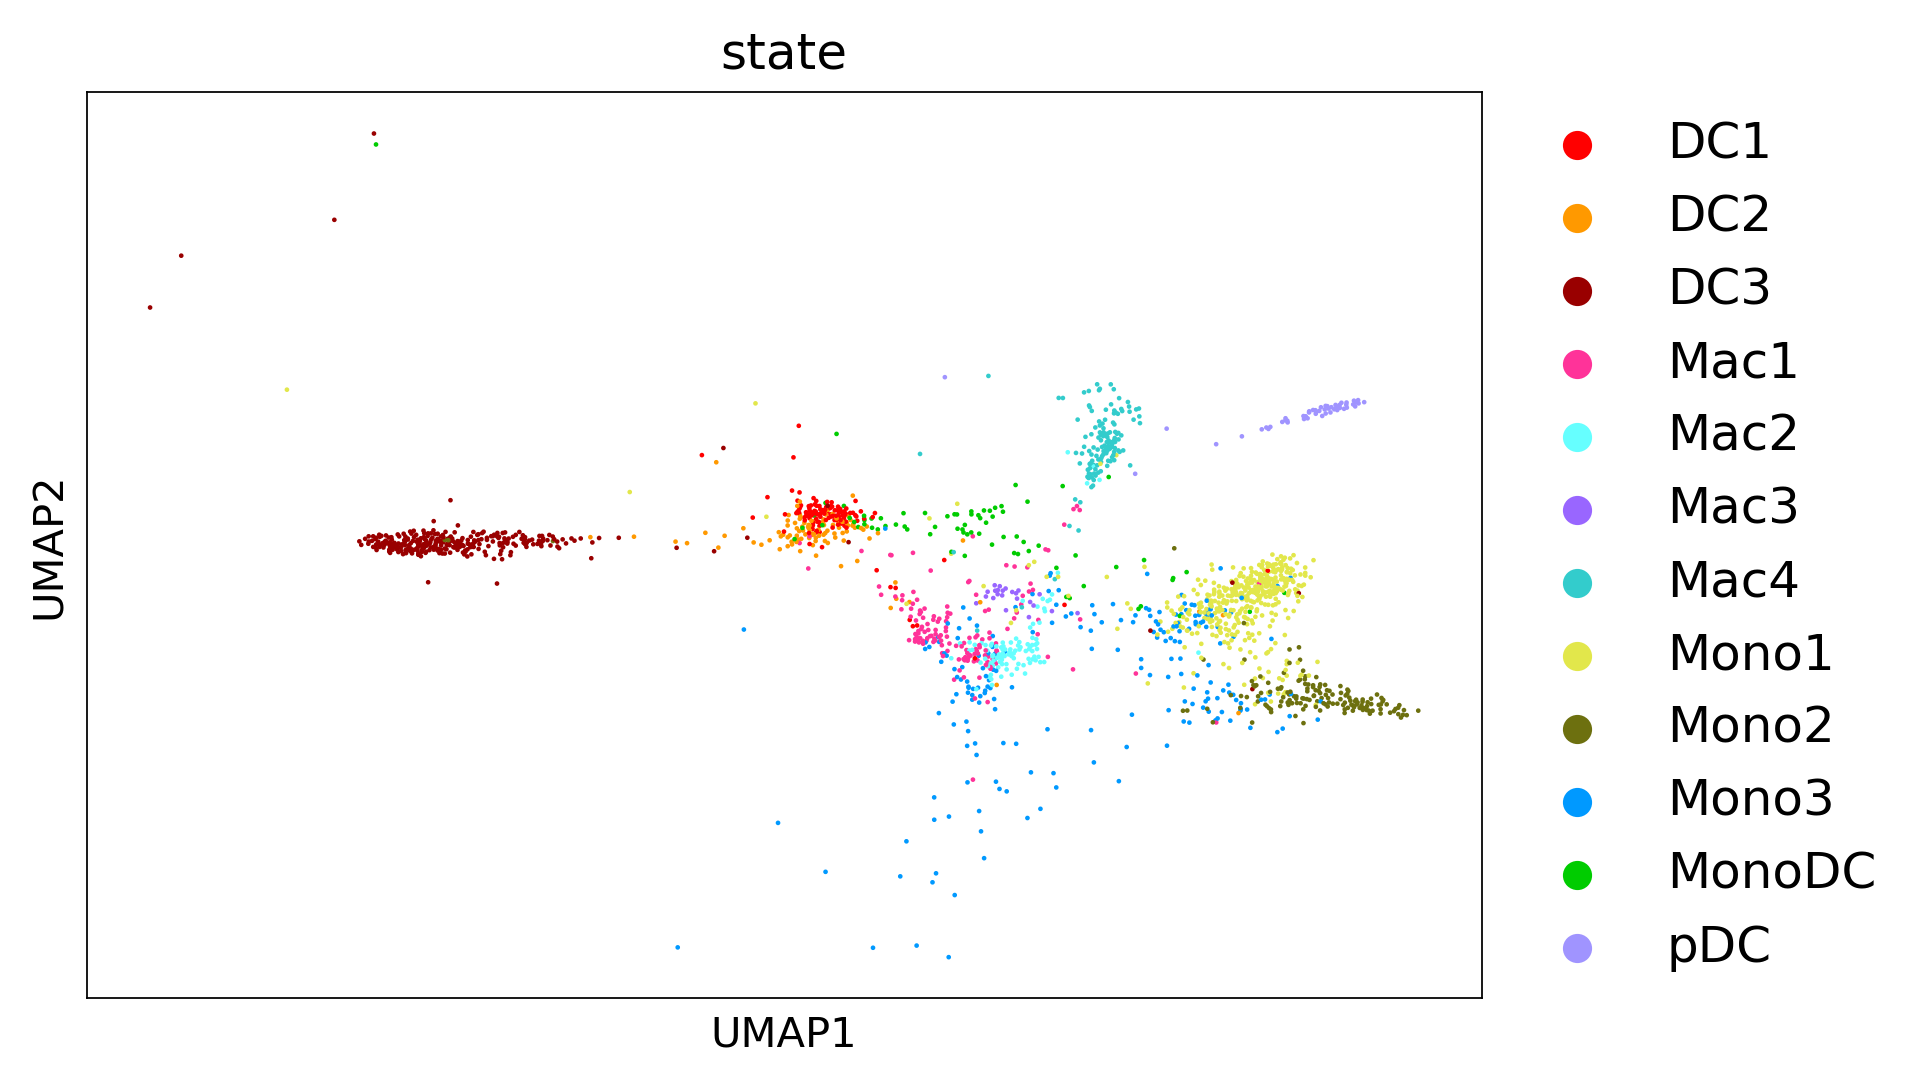

In [61]:
# plot cell state legend using Scanpy: 
sc.pl.umap(tmp_adata, color = 'state', s = 5, legend_fontsize = 12)

## Fig. S4B 

In [87]:
gmask = mm.gmask_outlier_genes(adata, min_counts = 1*adata.X.sum(1).mean()/1e4, min_cells = 4)

26200 genes are expressed in at least 4 cells with at least more than 0.243462060546875 counts per cell



In [88]:
chemokines = pd.read_csv('./chemokines_heatmap.csv')
chemokines 

,chemokines
0,Ccl1
1,Ccl11
2,Ccl17
3,Ccl19
4,Ccl2
5,Ccl20
6,Ccl21a
7,Ccl21b
8,Ccl21c
9,Ccl22


In [89]:
chemokines.values.flatten()

array(['Ccl1', 'Ccl11', 'Ccl17', 'Ccl19', 'Ccl2', 'Ccl20', 'Ccl21a',
       'Ccl21b', 'Ccl21c', 'Ccl22', 'Ccl24', 'Ccl25', 'Ccl26', 'Ccl27a',
       'Ccl27b', 'Ccl28', 'Ccl3', 'Ccl4', 'Ccl5', 'Ccl6', 'Ccl7', 'Ccl8',
       'Ccl9', 'Cx3cl1', 'Cxcl1', 'Cxcl10', 'Cxcl11', 'Cxcl12', 'Cxcl13',
       'Cxcl14', 'Cxcl15', 'Cxcl16', 'Cxcl17', 'Cxcl2', 'Cxcl5', 'Cxcl9',
       'Gm1960', 'Lix', 'Pf4', 'Ppbp', 'Xcl1', 'Ccl12', 'Ccl13', 'Ccl14',
       'Ccl15', 'Ccl16', 'Ccl18'], dtype=object)

In [90]:
chemokine_filt = [chemokine for chemokine in chemokines.values.flatten() if chemokine in adata[:, gmask].var_names]

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [91]:
chemokine_exp = mm.adata_centroids('state', adata[:, chemokine_filt])

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [92]:
heat = chemokine_exp + adata.X.sum(1).mean()/1e4
heat = heat/heat.median(0)
heat = np.log2(heat).T

In [93]:
heat = heat.sort_values('DC3', ascending = False)

In [94]:
apc_order = ['DC3', 'DC1', 'DC2', 'pDC', 'Mono1', 'Mono2', 'MonoDC', 'Mac1', 'Mac2','Mac3', 'Mac4', 
             #'Basophils','N1', 'N2', 'N3', 'N4', 'N5', 'N6', 
             'T1', 'T2', 'T3', 'NK cells', 'B cells']

In [95]:
heat = heat.loc[:, apc_order]
print(heat.min().min())
print(heat.max().max())

-3.5209022
6.4838676


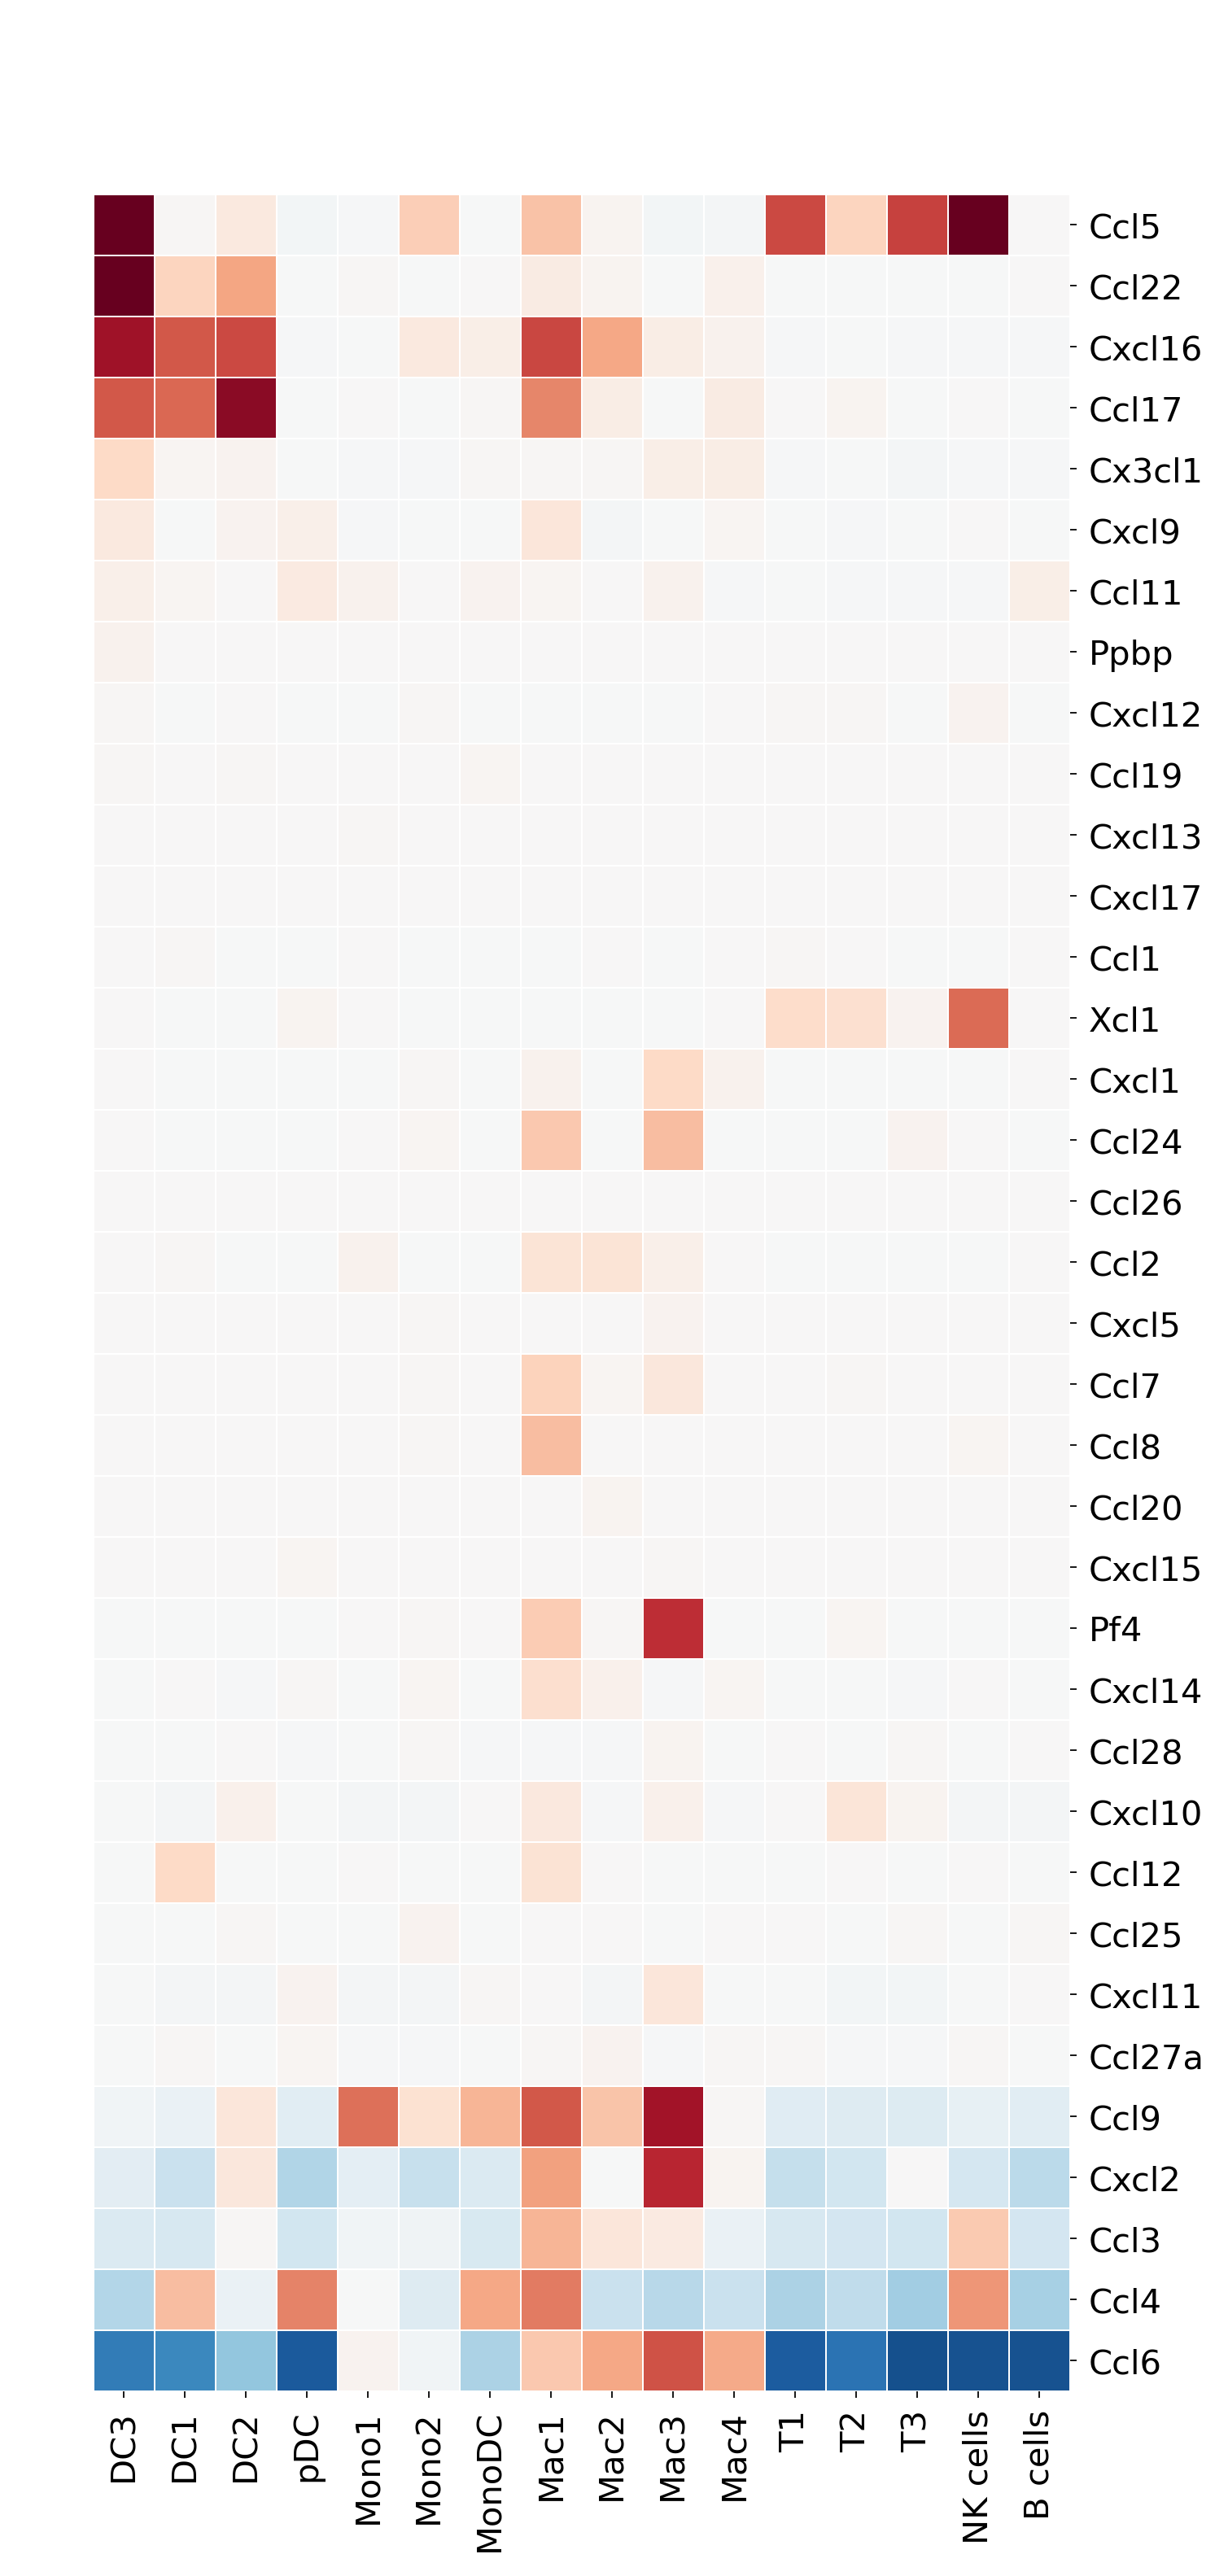

In [96]:
ax = mm.fixedWidthClusterMap(heat, row_cluster = False, col_cluster = False, cmap = plt.cm.get_cmap('RdBu_r'), 
                          linewidths = .25, cbar_pos = None, cellSizePixels=75, vmin = -4, vmax = 4)

mm.color_dataframe_cells(heat, vmin = -4, vmax = 4).to_excel('./outputs/KP19/neutrophils_heatmap_chemokines.xlsx')
ax.savefig('./outputs/KP19/neutrophils_heatmap_chemokines.pdf', dpi = 400)

## Fig. S6C

In [107]:
dc_cytokine_ligands = pd.read_csv('apc-b7-tnfsf-mhc-cytokine.csv', header = None).values.flatten()
dc_cytokine_ligands_filt = [gene for gene in dc_cytokine_ligands if gene in adata[:, gmask].var_names]
dc_cytokine_ligands_exp = mm.adata_centroids('state', adata[:, dc_cytokine_ligands_filt])

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [108]:
heat = dc_cytokine_ligands_exp + adata.X.sum(1).mean()/1e4
heat = heat/heat.median(0)
heat = np.log2(heat).T

In [109]:
apc_order = ['DC3', 'DC1', 'DC2', 'pDC', 'Mono1', 'Mono2', 'MonoDC', 'Mac1', 'Mac2', 'Mac3', 'Mac4', 
             #'N1', 'N2', 'N3', 'N4', 'N5', 'N6'
            ]

In [110]:
heat = heat.loc[:, apc_order]
print(heat.min().min())
print(heat.max().max())

-1.3554822
4.070815


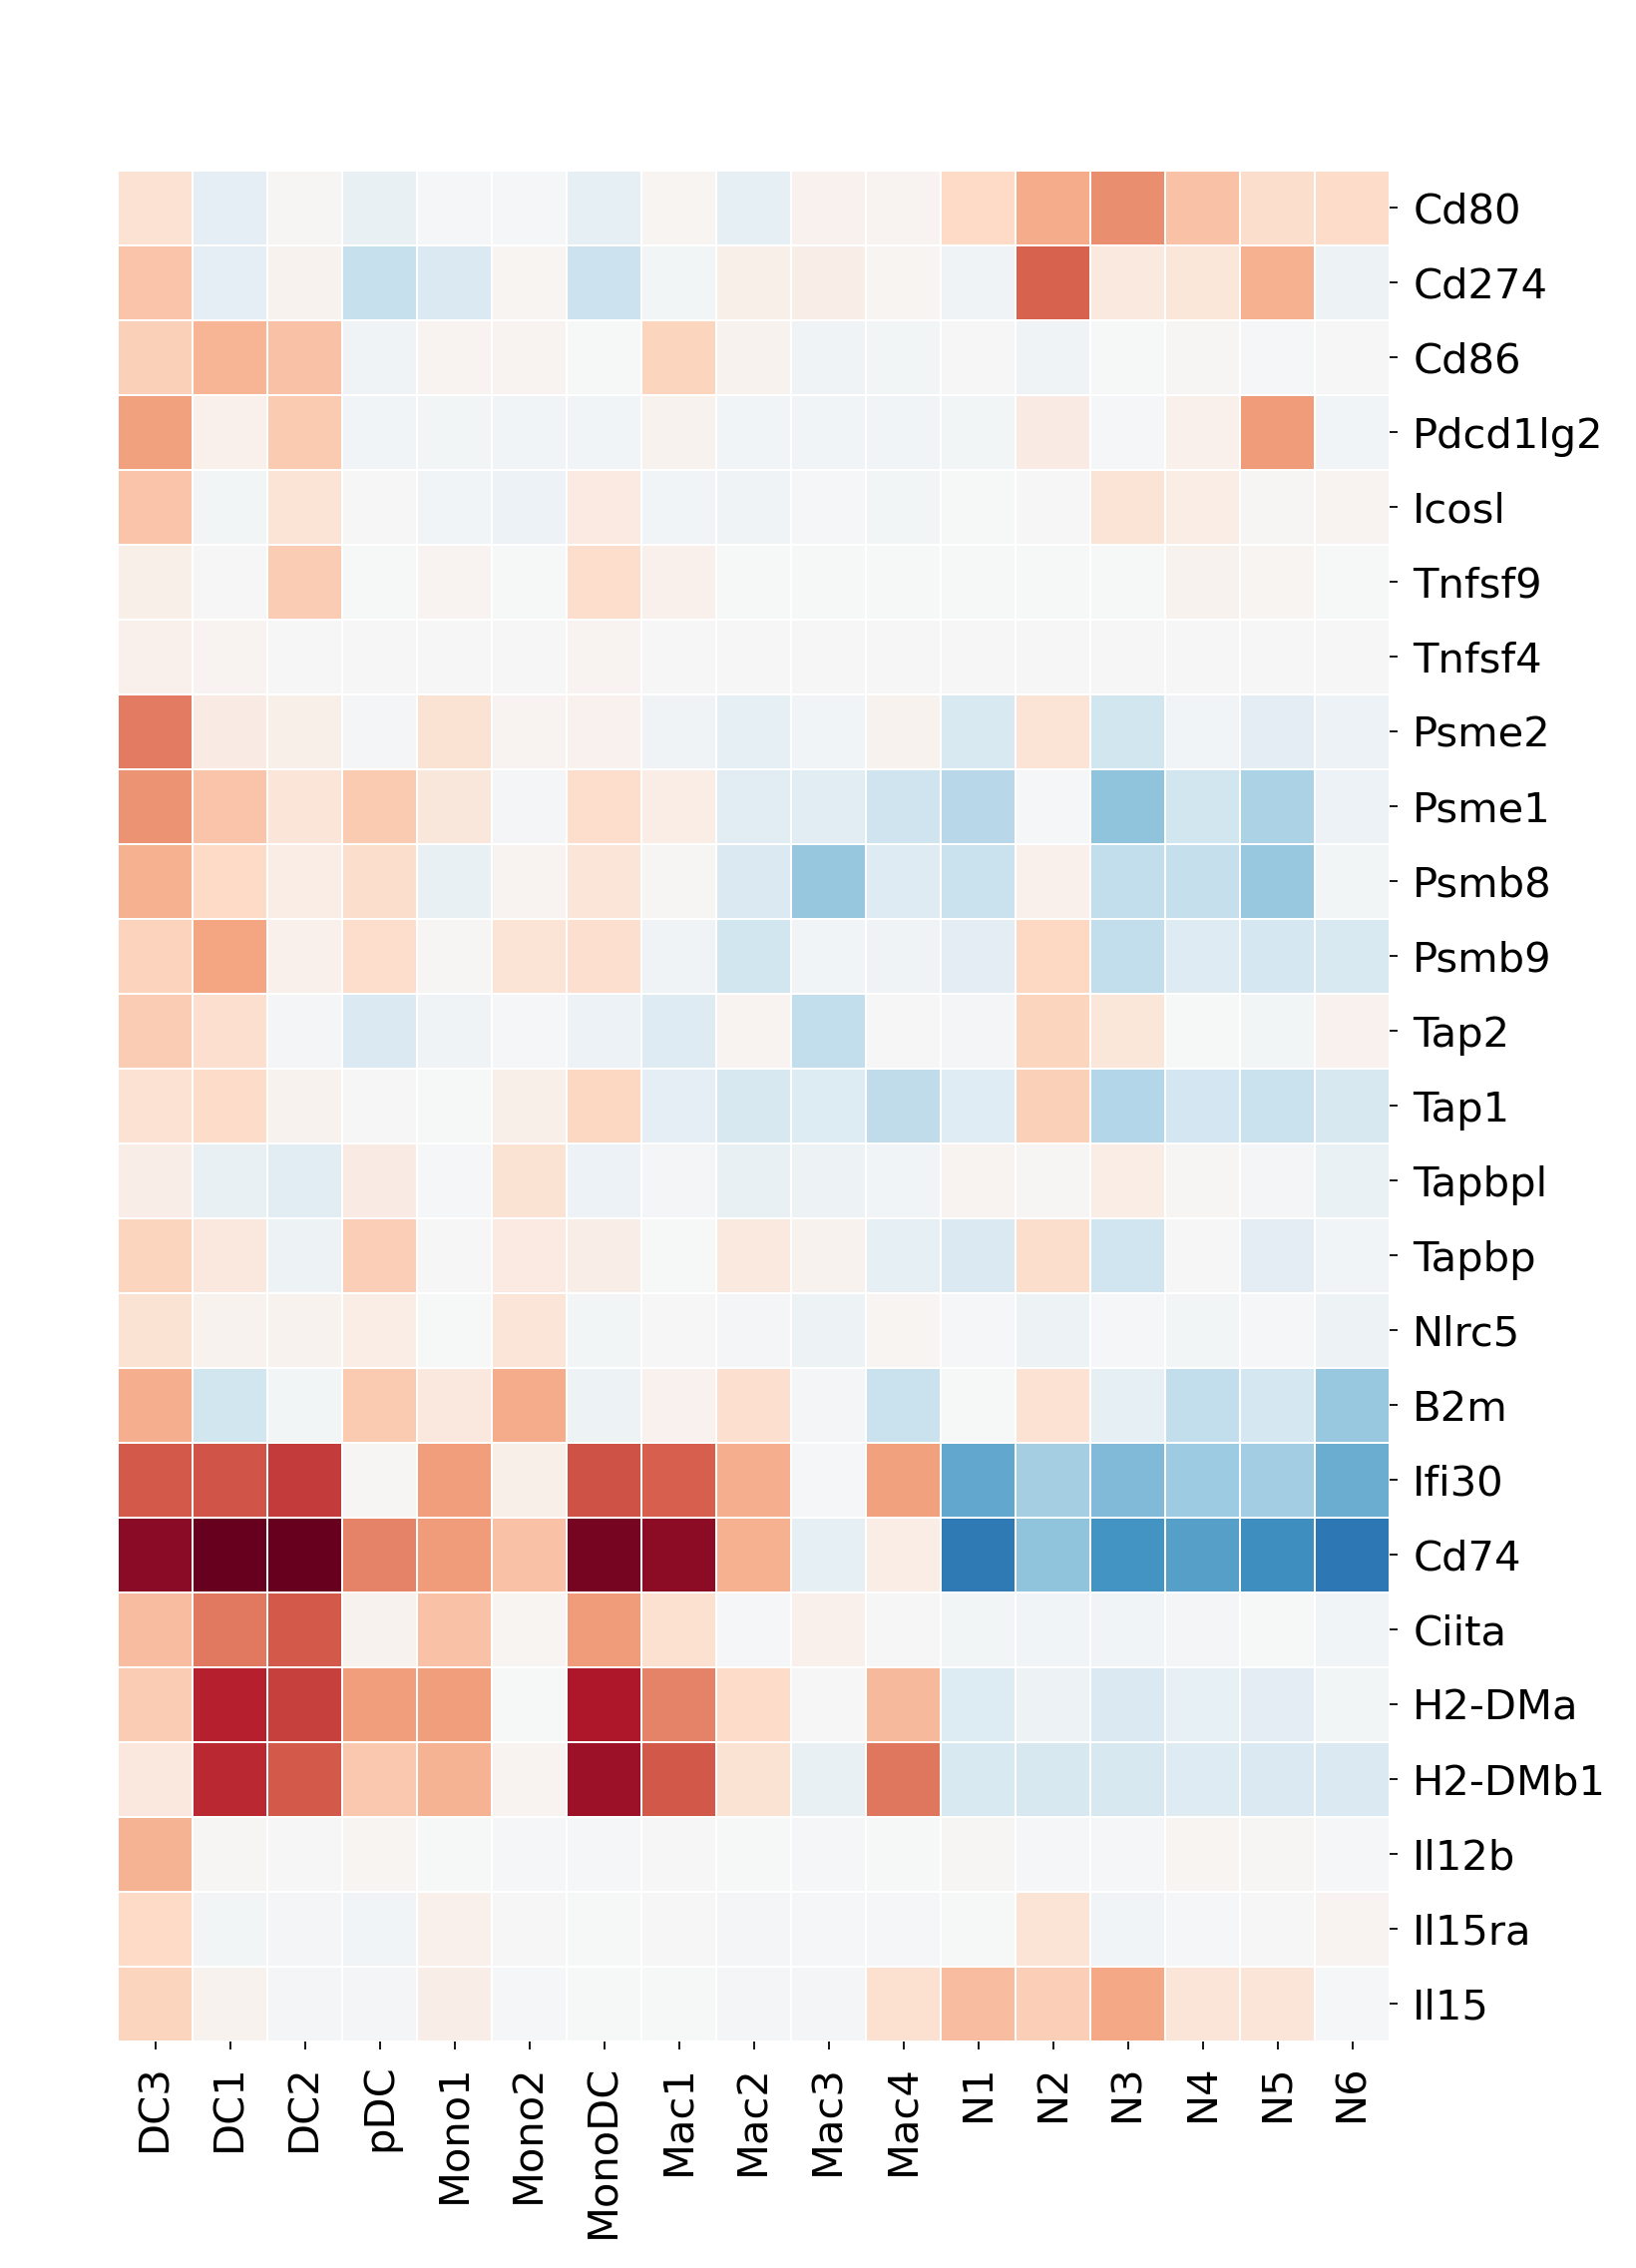

In [106]:
ax = mm.fixedWidthClusterMap(heat, row_cluster = False, col_cluster = False, cmap = plt.cm.get_cmap('RdBu_r'), 
                          linewidths = .25, cbar_pos = None, cellSizePixels=75, vmin = -3.5, vmax = 3.5)

mm.color_dataframe_cells(heat, vmin = -3, vmax = 3).to_excel('./outputs/KP19/heatmap_apc-b7-tnfsf-mhc-cytokine.xlsx')
ax.savefig('./outputs/KP19/heatmap_apc-b7-tnfsf-mhc-cytokine.pdf', dpi = 400)